In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [2]:
current_env = "local"

if current_env == "local":
    data_path = "../ump-dataset"

elif current_env == "kaggle":
    data_path = "../input/ump-dataset"
    
elif current_env == "colab":
    pass

print("data_path:", data_path)

data_path: ../ump-dataset


***
## loading data

In [3]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet(f"{data_path}/train.parquet", columns=features)
target = pd.read_parquet(f"{data_path}/train.parquet", columns=["target",])
time = pd.read_parquet(f"{data_path}/train.parquet", columns=["time_id",])

In [4]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [5]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.1
valid_size = int(0.1 * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 121


In [6]:
# train-valid splits
n_splits = 3
end_idx = n_time_steps 

splits = list()

for start_idx in np.arange(1211, 0, -valid_size)[1:n_splits+1]:
    valid_time_ids = time_ids[start_idx:end_idx]
    train_time_end = time_ids[start_idx]-1
    end_idx = start_idx
    
    train_idx = time.query("time_id <= @train_time_end").index
    valid_idx = time.query("time_id in @valid_time_ids").index
    splits.append((train_idx,valid_idx))

In [7]:
import gc
gc.collect()

153

***
## model training: finding number of iterations

In [8]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [9]:
model_params = {
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 128,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'verbosity': -1,
    'first_metric_only': False,
    'bin_construct_sample_cnt': 100000000,
    'feature_pre_filter': False,
    'bagging_fraction': 1.0,
    'feature_fraction': 0.15,
    'lambda_l1': 0.3406400464644552,
    'lambda_l2': 3.2481088372420728,
    'min_data_in_leaf': 1900,
    'num_iterations': 800,
    'path_smooth': 48.076544759497345,
    'max_bin': 511,
}

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[20]	valid_0's rmse: 0.899094	valid_0's pearsonr: 0.123083
[40]	valid_0's rmse: 0.897212	valid_0's pearsonr: 0.130115
[60]	valid_0's rmse: 0.896445	valid_0's pearsonr: 0.131596
[80]	valid_0's rmse: 0.896002	valid_0's pearsonr: 0.132491
[100]	valid_0's rmse: 0.89569	valid_0's pearsonr: 0.133454
[120]	valid_0's rmse: 0.895446	valid_0's pearsonr: 0.134248
[140]	valid_0's rmse: 0.895265	valid_0's pearsonr: 0.134928
[160]	valid_0's rmse: 0.895128	valid_0's pearsonr: 0.135309
[180]	valid_0's rmse: 0.894981	valid_0's pearsonr: 0.136084
[200]	valid_0's rmse: 0.894864	valid_0's pearsonr: 0.136706
[220]	valid_0's rmse: 0.894788	valid_0's pearsonr: 0.13704
[240]	valid_0's rmse: 0.894753	valid_0's pearsonr: 0.137109
[260]	valid_0's rmse: 0.894751	valid_0's pearsonr: 0.136989
[280]	valid_0's rmse: 0.894718	valid_0's pearsonr: 0.137188
[300]	valid_0's rmse: 0.894727	valid_0's pearsonr: 0.137086
[320]	valid_0's rmse: 0.894706	valid_0's pearsonr: 0.137267
[340]	valid_0's rmse: 0.894637	valid_0's pears

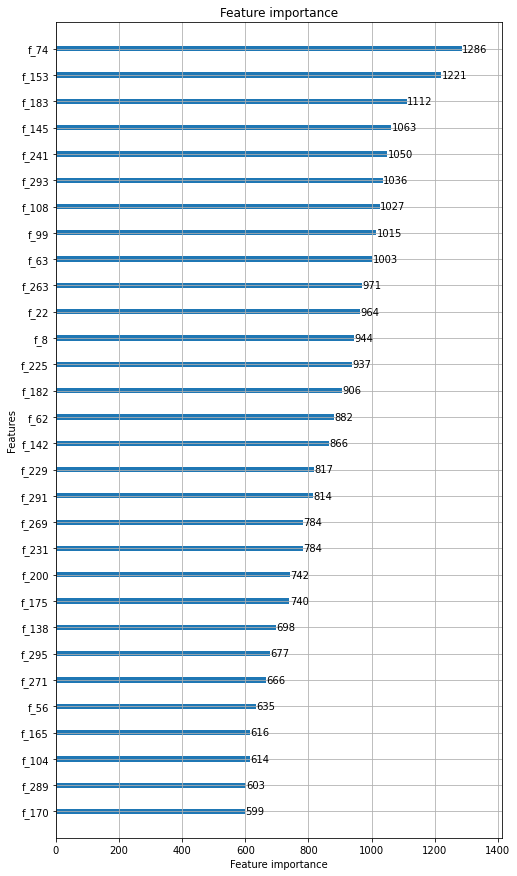

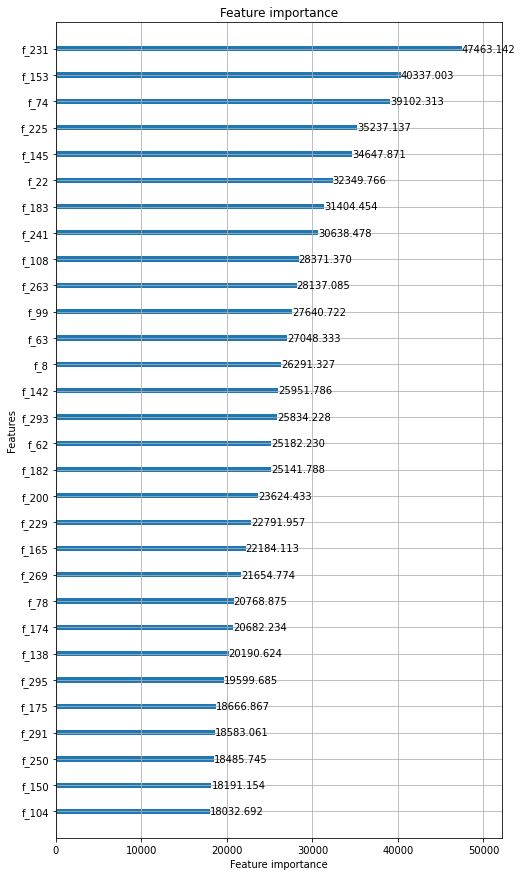

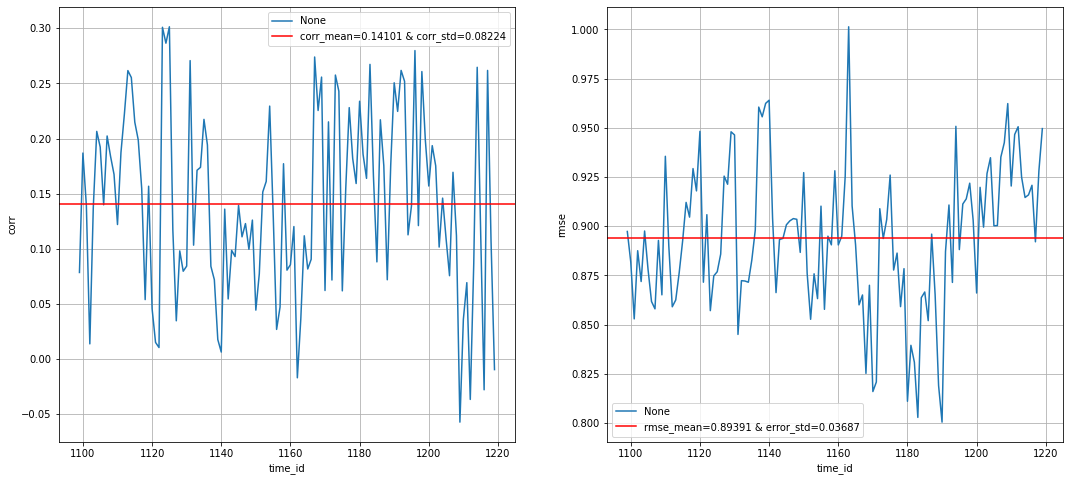

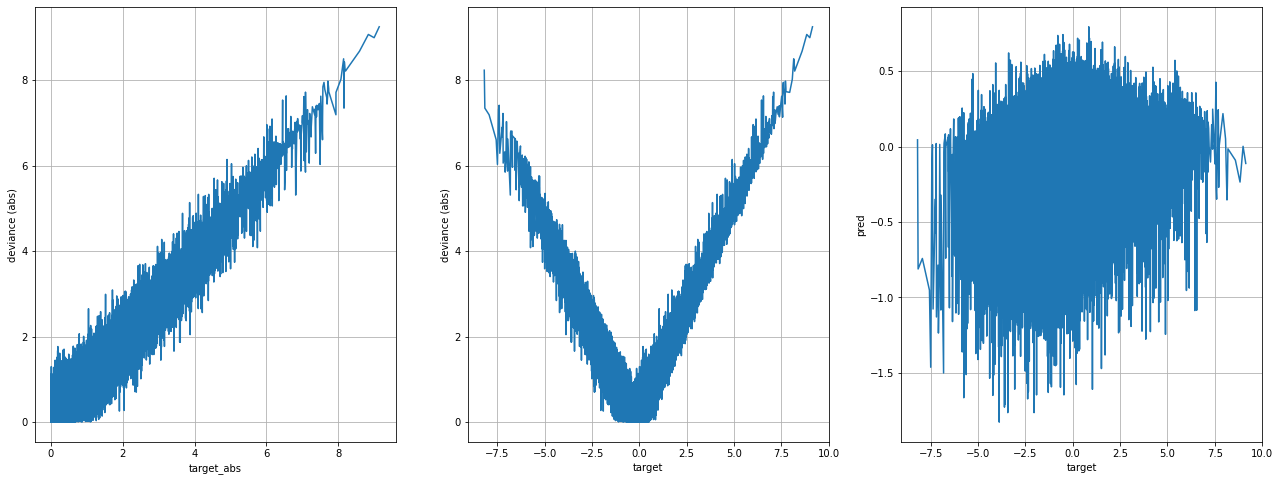

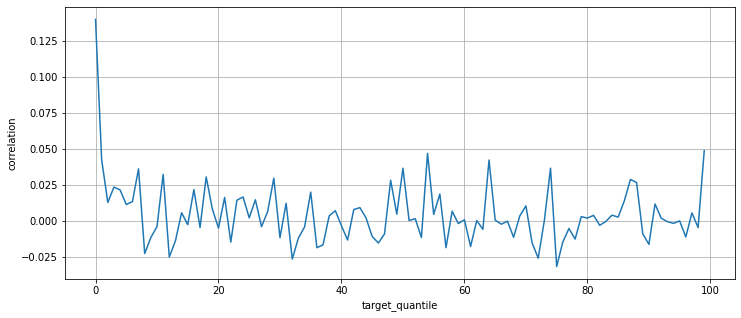

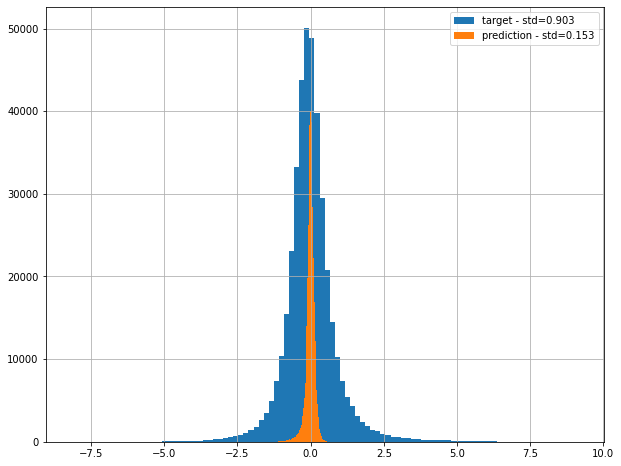

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[20]	valid_0's rmse: 0.906676	valid_0's pearsonr: 0.110021
[40]	valid_0's rmse: 0.904888	valid_0's pearsonr: 0.120229
[60]	valid_0's rmse: 0.903992	valid_0's pearsonr: 0.124873
[80]	valid_0's rmse: 0.903268	valid_0's pearsonr: 0.129679
[100]	valid_0's rmse: 0.902786	valid_0's pearsonr: 0.132441
[120]	valid_0's rmse: 0.902431	valid_0's pearsonr: 0.134437
[140]	valid_0's rmse: 0.902067	valid_0's pearsonr: 0.136832
[160]	valid_0's rmse: 0.901842	valid_0's pearsonr: 0.137776
[180]	valid_0's rmse: 0.901674	valid_0's pearsonr: 0.138514
[200]	valid_0's rmse: 0.901574	valid_0's pearsonr: 0.138707
[220]	valid_0's rmse: 0.901434	valid_0's pearsonr: 0.139465
[240]	valid_0's rmse: 0.901311	valid_0's pearsonr: 0.140166
[260]	valid_0's rmse: 0.901198	valid_0's pearsonr: 0.140801
[280]	valid_0's rmse: 0.901144	valid_0's pearsonr: 0.140987
[300]	valid_0's rmse: 0.901138	valid_0's pearsonr: 0.140849
[320]	valid_0's rmse: 0.901128	valid_0's pearsonr: 0.140793
[340]	valid_0's rmse: 0.901118	valid_0's pea

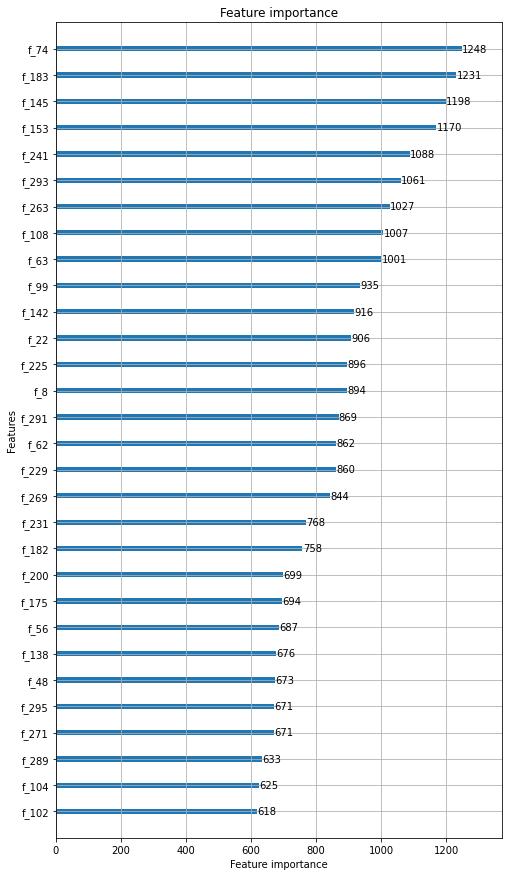

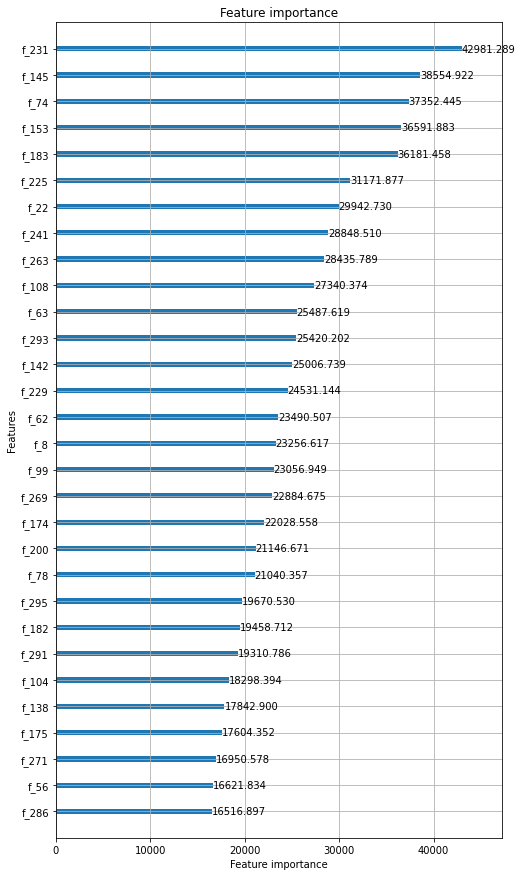

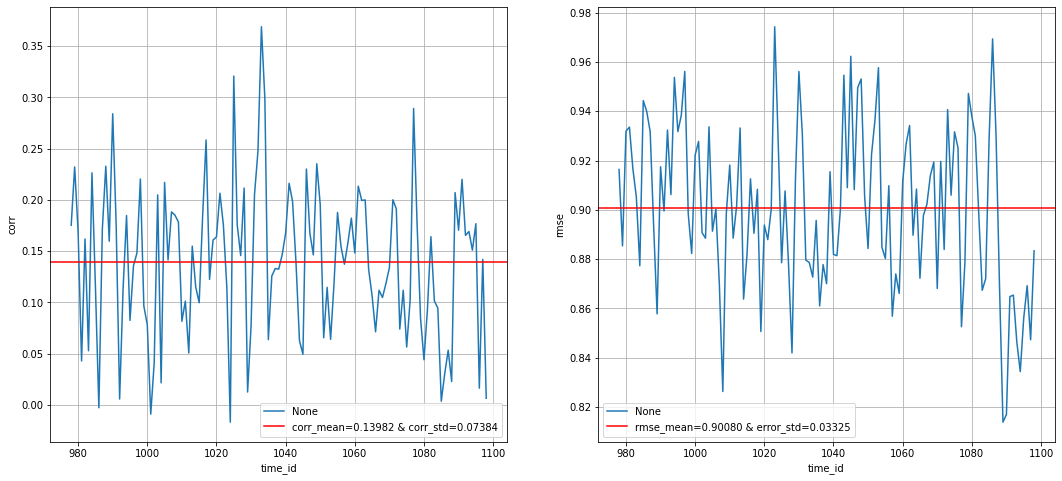

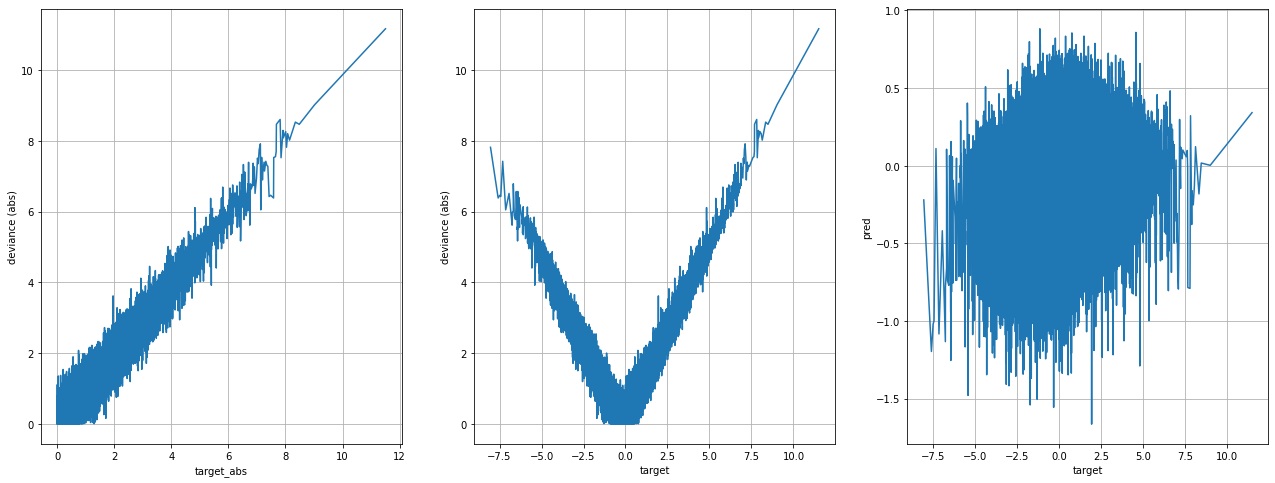

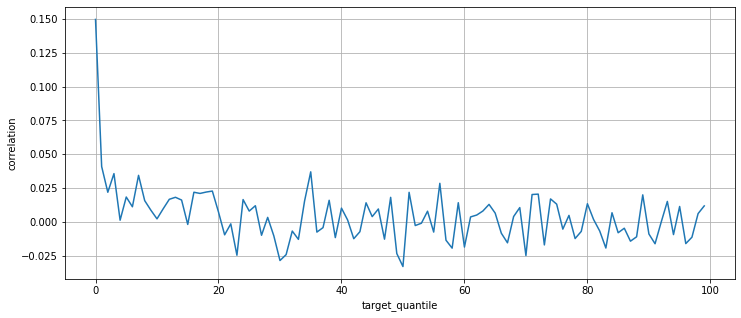

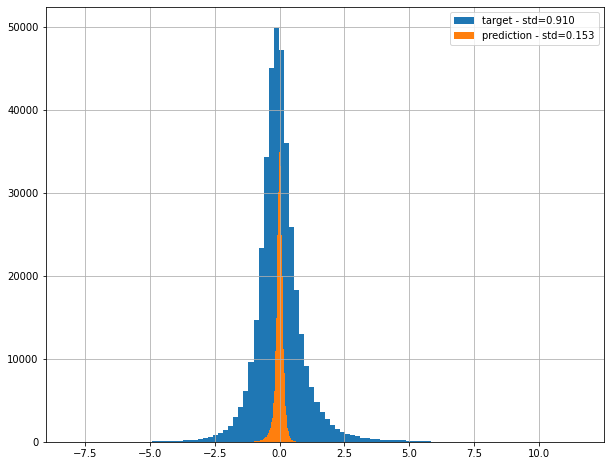

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[20]	valid_0's rmse: 0.940786	valid_0's pearsonr: 0.0930544
[40]	valid_0's rmse: 0.939405	valid_0's pearsonr: 0.102964
[60]	valid_0's rmse: 0.938709	valid_0's pearsonr: 0.107619
[80]	valid_0's rmse: 0.938214	valid_0's pearsonr: 0.111259
[100]	valid_0's rmse: 0.93778	valid_0's pearsonr: 0.114794
[120]	valid_0's rmse: 0.937407	valid_0's pearsonr: 0.117736
[140]	valid_0's rmse: 0.937043	valid_0's pearsonr: 0.120712
[160]	valid_0's rmse: 0.936724	valid_0's pearsonr: 0.123234
[180]	valid_0's rmse: 0.936393	valid_0's pearsonr: 0.125905
[200]	valid_0's rmse: 0.9362	valid_0's pearsonr: 0.127322
[220]	valid_0's rmse: 0.936084	valid_0's pearsonr: 0.128143
[240]	valid_0's rmse: 0.935931	valid_0's pearsonr: 0.129326
[260]	valid_0's rmse: 0.935751	valid_0's pearsonr: 0.130751
[280]	valid_0's rmse: 0.935619	valid_0's pearsonr: 0.131774
[300]	valid_0's rmse: 0.935457	valid_0's pearsonr: 0.133057
[320]	valid_0's rmse: 0.935371	valid_0's pearsonr: 0.133721
[340]	valid_0's rmse: 0.935297	valid_0's pears

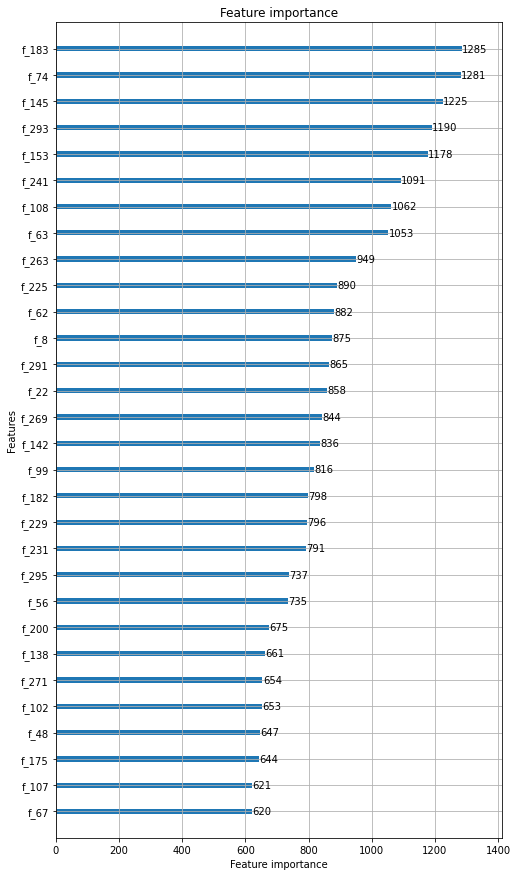

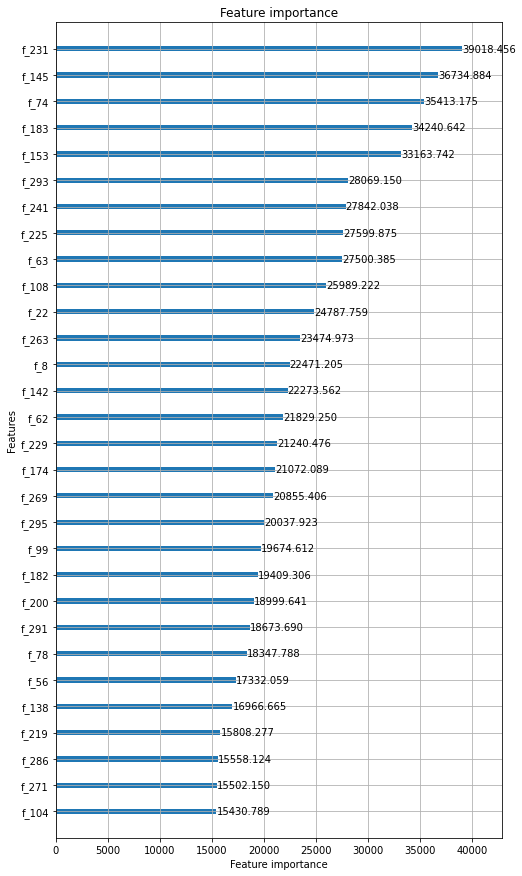

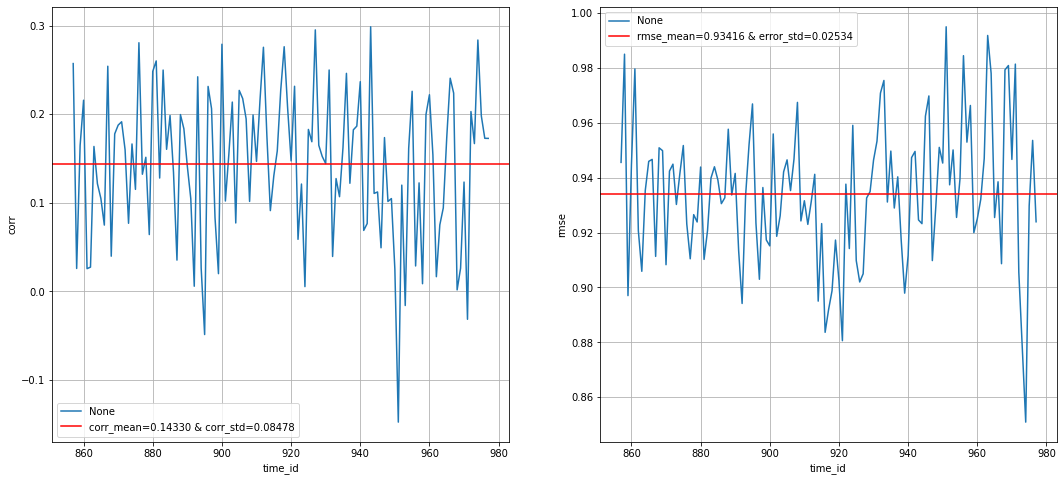

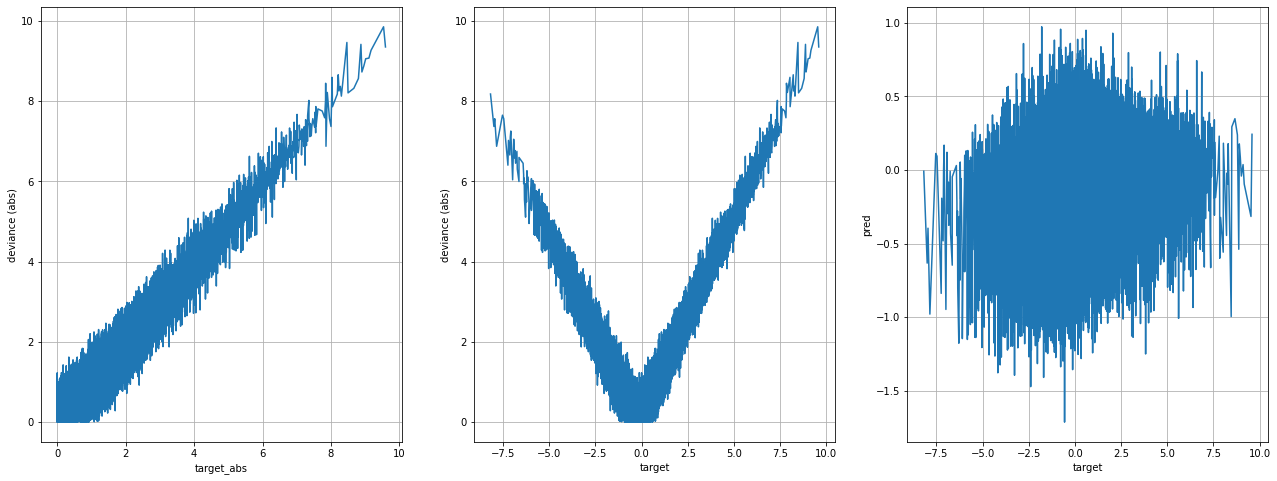

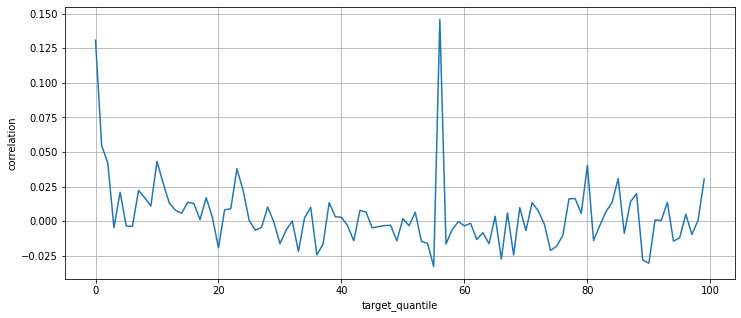

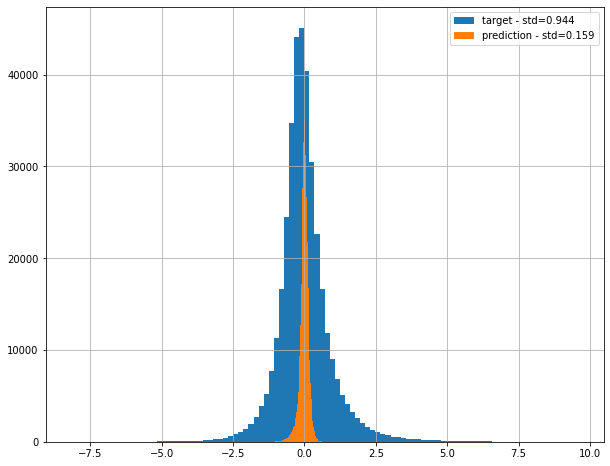

In [10]:
do_evaluation = True
metrics = {
    "corr_mean":list(), 
    "corr_std":list(), 
    "error_mean":list(), 
    "error_std":list(),
}

if do_evaluation:
    
    models = list()

    for train_idx,valid_idx in splits:

        train_dset = lgb.Dataset(
            data=features.loc[train_idx,:],
            label=target.loc[train_idx,"target"].values,
            free_raw_data=True
        )
        valid_dset = lgb.Dataset(
            data=features.loc[valid_idx,:],
            label=target.loc[valid_idx,"target"].values,
            free_raw_data=True
        )
        log_callback = lgb.log_evaluation(period=20,)

        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=pearsonr,
            callbacks=[log_callback],
        )
        models.append(model)

        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()
        
        # residual analysis on oof predictions
        oof = target.loc[valid_idx,:].copy()
        oof["time_id"] = time.loc[valid_idx,"time_id"]
        oof["pred"] = model.predict(features.loc[valid_idx,:])
        oof["target_abs"] = oof.eval("abs(target)")
        oof["dev"] = oof.eval("abs(target-pred)")

        corrs = oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
        corr_mean = corrs.mean()
        corr_std = corrs.std()
        error = oof.groupby("time_id").apply(lambda x: np.sqrt(np.mean((x.target-x.pred)**2)))
        error_mean = error.mean()
        error_std = error.std()
        
        metrics["corr_mean"].append(corr_mean)
        metrics["corr_std"].append(corr_std)
        metrics["error_mean"].append(error_mean)
        metrics["error_std"].append(error_std)

        plt.figure(figsize=(18,8))
        plt.subplot(1,2,1)
        corrs.plot()
        plt.axhline(
            y=corr_mean, 
            color='r', 
            linestyle='-', 
            label=f"corr_mean={corr_mean:.5f} & corr_std={corr_std:.5f}"
        )
        plt.grid()
        plt.ylabel("corr")
        plt.legend(loc="best")
        ##
        plt.subplot(1,2,2)
        error.plot()
        plt.axhline(
            y=error_mean, 
            color='r', 
            linestyle='-', 
            label=f"rmse_mean={error_mean:.5f} & error_std={error_std:.5f}"
        )
        plt.grid()
        plt.ylabel("rmse")
        plt.legend(loc="best")
        plt.show()

        plt.figure(figsize=(22,8))
        ##
        plt.subplot(1,3,1)
        plt.plot(oof.sort_values("target_abs").target_abs.values, oof.sort_values("target_abs").dev.values)
        plt.xlabel("target_abs")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,2)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").dev.values)
        plt.xlabel("target")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,3)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").pred.values)
        plt.xlabel("target")
        plt.ylabel("pred")
        plt.grid()
        plt.show()
        
        ## correlation vs target value
        oof["target_pct"] = ((100-1e-10)*oof.target.rank(pct=True)).astype(int)
        #oof["target_pct"] = 5*(oof.target_pct/5).astype(int)

        bucket_corr = (
            oof
            .groupby("target_pct")
            .apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
            .reset_index()
            .rename({0:"corr"}, axis=1)
        )

        plt.figure(figsize=(12,5))
        plt.plot(bucket_corr["target_pct"], bucket_corr["corr"])
        plt.xlabel("target_quantile")
        plt.ylabel("correlation")
        plt.grid()
        plt.show()
        
        plt.figure(figsize=(10,8))
        plt.hist(oof.target, bins=100, label=f"target - std={oof.target.std():0.3f}")
        plt.hist(oof.pred, bins=100, label=f"prediction - std={oof.pred.std():0.3f}")
        plt.grid()
        plt.legend(loc="best")
        plt.show()


In [11]:
metrics

{'corr_mean': [0.1410147140470899, 0.13981617687008777, 0.14329616844829482],
 'corr_std': [0.08223611446630623, 0.07384402920290606, 0.08477855146510514],
 'error_mean': [0.8939076306463319, 0.9008042619685919, 0.9341607452678301],
 'error_std': [0.03686991968300542,
  0.033254942709966664,
  0.025343991580314064]}

In [12]:
# mean corr on validation
np.mean(metrics["corr_mean"])

0.1413756864551575

In [13]:
# mean rmse on validation
np.mean(metrics["error_mean"])

0.9096242126275845

***
## model training

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[20]	training's rmse: 0.913892	training's pearsonr: 0.147182
[40]	training's rmse: 0.910619	training's pearsonr: 0.164784
[60]	training's rmse: 0.908127	training's pearsonr: 0.179872
[80]	training's rmse: 0.906087	training's pearsonr: 0.192577
[100]	training's rmse: 0.90418	training's pearsonr: 0.204324
[120]	training's rmse: 0.902555	training's pearsonr: 0.214227
[140]	training's rmse: 0.901011	training's pearsonr: 0.223184
[160]	training's rmse: 0.899513	training's pearsonr: 0.231682
[180]	training's rmse: 0.898007	training's pearsonr: 0.24001
[200]	training's rmse: 0.896661	training's pearsonr: 0.247355
[220]	training's rmse: 0.895259	training's pearsonr: 0.254829
[240]	training's rmse: 0.893945	training's pearsonr: 0.261541
[260]	training's rmse: 0.89278	training's pearsonr: 0.267091
[280]	training's rmse: 0.891494	training's pearsonr: 0.273461
[300]	training's rmse: 0.890307	training's pearsonr: 0.279095
[320]	training's rmse: 0.889197	training's pearsonr: 0.284184
[340]	training'

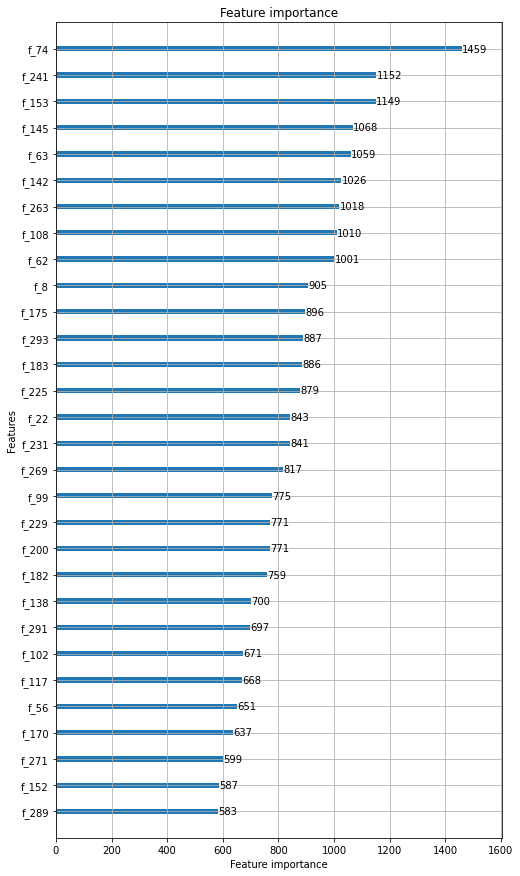

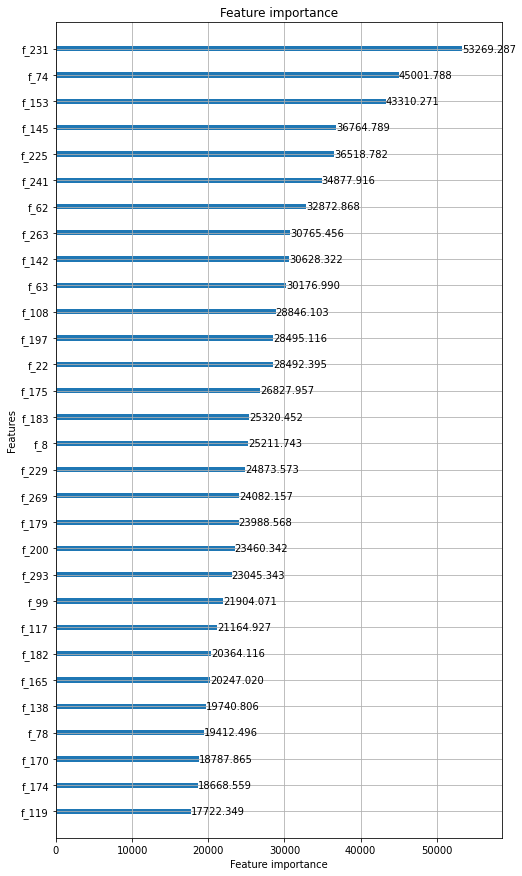

[20]	training's rmse: 0.913876	training's pearsonr: 0.146579
[40]	training's rmse: 0.910619	training's pearsonr: 0.164207
[60]	training's rmse: 0.908211	training's pearsonr: 0.178569
[80]	training's rmse: 0.906243	training's pearsonr: 0.191263
[100]	training's rmse: 0.90444	training's pearsonr: 0.203048
[120]	training's rmse: 0.902772	training's pearsonr: 0.213262
[140]	training's rmse: 0.901233	training's pearsonr: 0.222217
[160]	training's rmse: 0.899709	training's pearsonr: 0.230915
[180]	training's rmse: 0.898238	training's pearsonr: 0.23902
[200]	training's rmse: 0.896882	training's pearsonr: 0.24634
[220]	training's rmse: 0.895567	training's pearsonr: 0.253197
[240]	training's rmse: 0.894335	training's pearsonr: 0.259316
[260]	training's rmse: 0.893094	training's pearsonr: 0.265452
[280]	training's rmse: 0.891895	training's pearsonr: 0.271495
[300]	training's rmse: 0.890683	training's pearsonr: 0.277241
[320]	training's rmse: 0.88955	training's pearsonr: 0.282437
[340]	training's

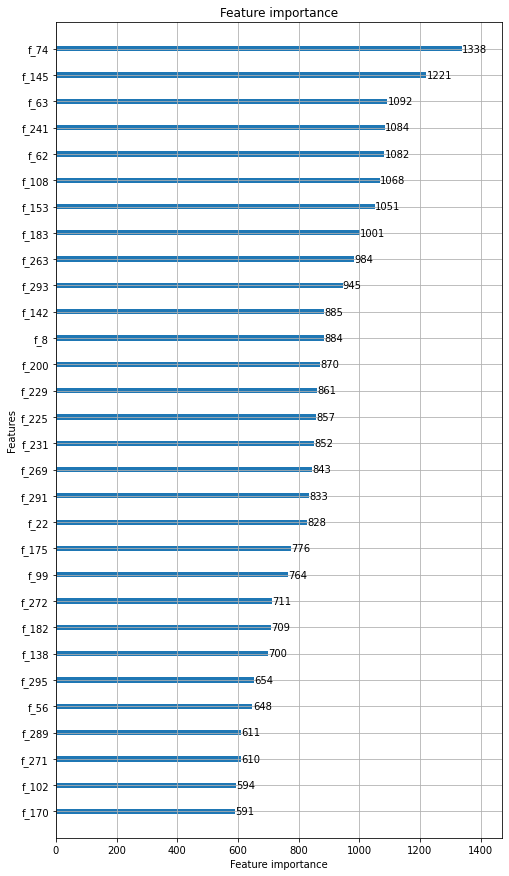

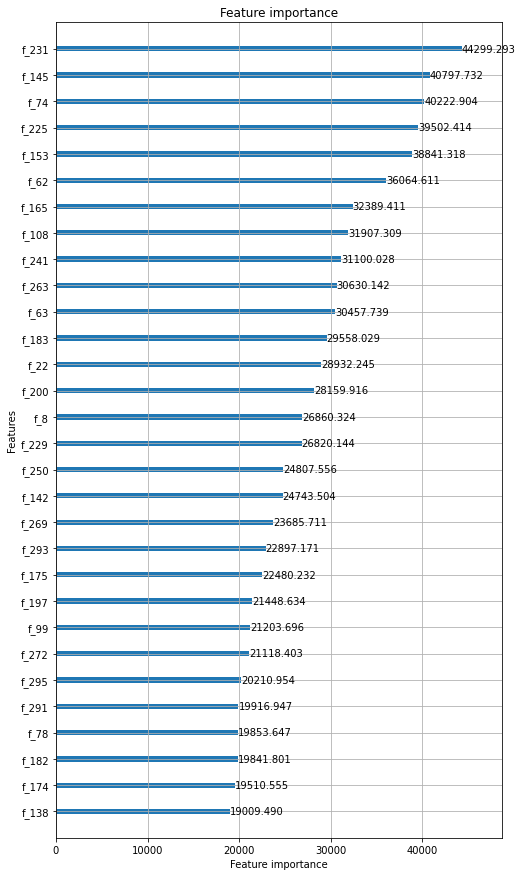

[20]	training's rmse: 0.913801	training's pearsonr: 0.148135
[40]	training's rmse: 0.910546	training's pearsonr: 0.163939
[60]	training's rmse: 0.908199	training's pearsonr: 0.178417
[80]	training's rmse: 0.906063	training's pearsonr: 0.192311
[100]	training's rmse: 0.904372	training's pearsonr: 0.202911
[120]	training's rmse: 0.902762	training's pearsonr: 0.212574
[140]	training's rmse: 0.901192	training's pearsonr: 0.221994
[160]	training's rmse: 0.899777	training's pearsonr: 0.230022
[180]	training's rmse: 0.898262	training's pearsonr: 0.238595
[200]	training's rmse: 0.896921	training's pearsonr: 0.24598
[220]	training's rmse: 0.895561	training's pearsonr: 0.253098
[240]	training's rmse: 0.894225	training's pearsonr: 0.259855
[260]	training's rmse: 0.893067	training's pearsonr: 0.265532
[280]	training's rmse: 0.891874	training's pearsonr: 0.271742
[300]	training's rmse: 0.890694	training's pearsonr: 0.277379
[320]	training's rmse: 0.889568	training's pearsonr: 0.282728
[340]	trainin

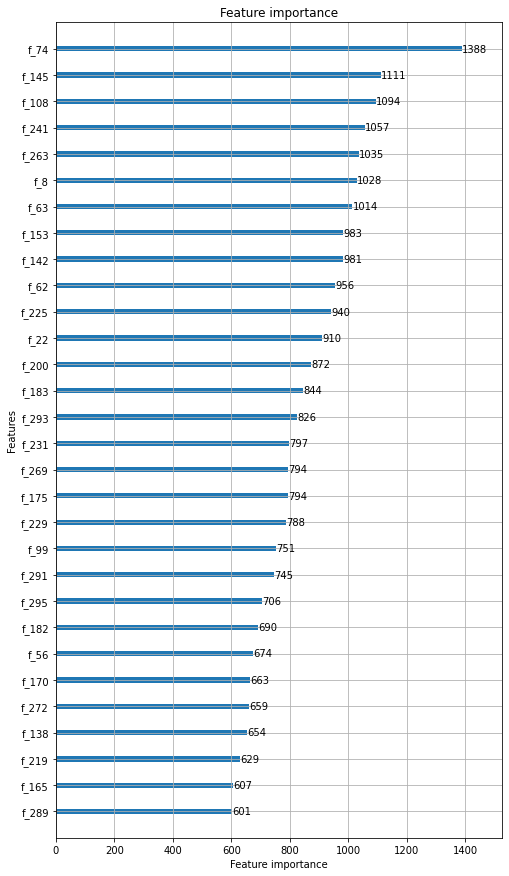

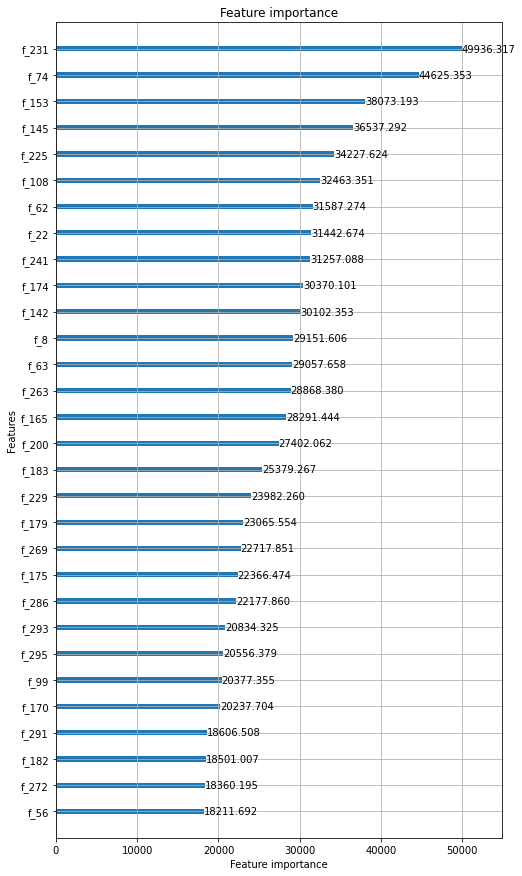

[20]	training's rmse: 0.913847	training's pearsonr: 0.146699
[40]	training's rmse: 0.910449	training's pearsonr: 0.164772
[60]	training's rmse: 0.908085	training's pearsonr: 0.179118
[80]	training's rmse: 0.906139	training's pearsonr: 0.19144
[100]	training's rmse: 0.904275	training's pearsonr: 0.203346
[120]	training's rmse: 0.902682	training's pearsonr: 0.213149
[140]	training's rmse: 0.901115	training's pearsonr: 0.222697
[160]	training's rmse: 0.899608	training's pearsonr: 0.231294
[180]	training's rmse: 0.898281	training's pearsonr: 0.238697
[200]	training's rmse: 0.896913	training's pearsonr: 0.246203
[220]	training's rmse: 0.895592	training's pearsonr: 0.25316
[240]	training's rmse: 0.894299	training's pearsonr: 0.259622
[260]	training's rmse: 0.893103	training's pearsonr: 0.265691
[280]	training's rmse: 0.891904	training's pearsonr: 0.27158
[300]	training's rmse: 0.890743	training's pearsonr: 0.277163
[320]	training's rmse: 0.889664	training's pearsonr: 0.282274
[340]	training'

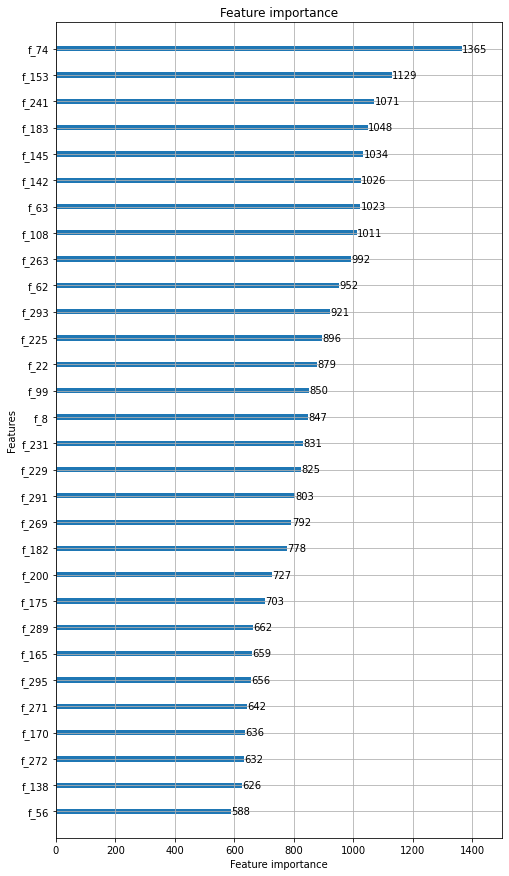

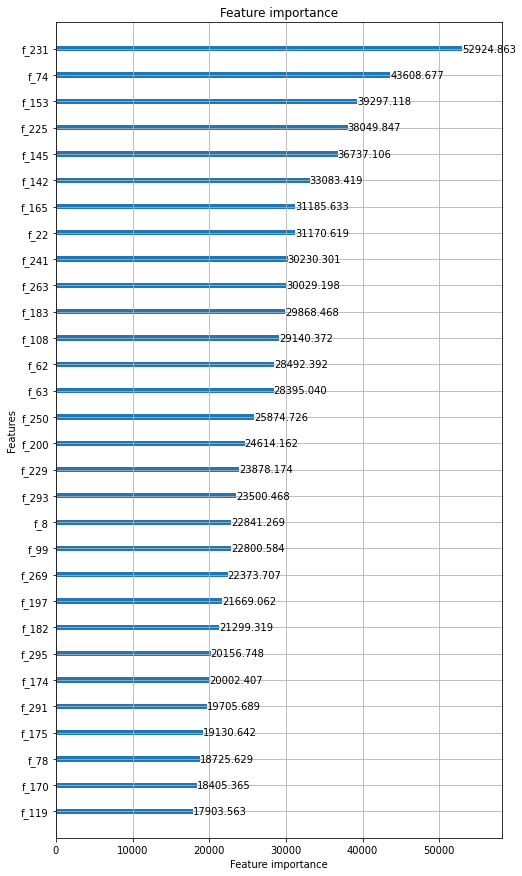

[20]	training's rmse: 0.913708	training's pearsonr: 0.148836
[40]	training's rmse: 0.910394	training's pearsonr: 0.165856
[60]	training's rmse: 0.908032	training's pearsonr: 0.179639
[80]	training's rmse: 0.906016	training's pearsonr: 0.192322
[100]	training's rmse: 0.904283	training's pearsonr: 0.203165
[120]	training's rmse: 0.902494	training's pearsonr: 0.214446
[140]	training's rmse: 0.900974	training's pearsonr: 0.223555
[160]	training's rmse: 0.89957	training's pearsonr: 0.231533
[180]	training's rmse: 0.898169	training's pearsonr: 0.239384
[200]	training's rmse: 0.896792	training's pearsonr: 0.246964
[220]	training's rmse: 0.895536	training's pearsonr: 0.253414
[240]	training's rmse: 0.894258	training's pearsonr: 0.259955
[260]	training's rmse: 0.893075	training's pearsonr: 0.265781
[280]	training's rmse: 0.891814	training's pearsonr: 0.272002
[300]	training's rmse: 0.890667	training's pearsonr: 0.27749
[320]	training's rmse: 0.889545	training's pearsonr: 0.282834
[340]	training

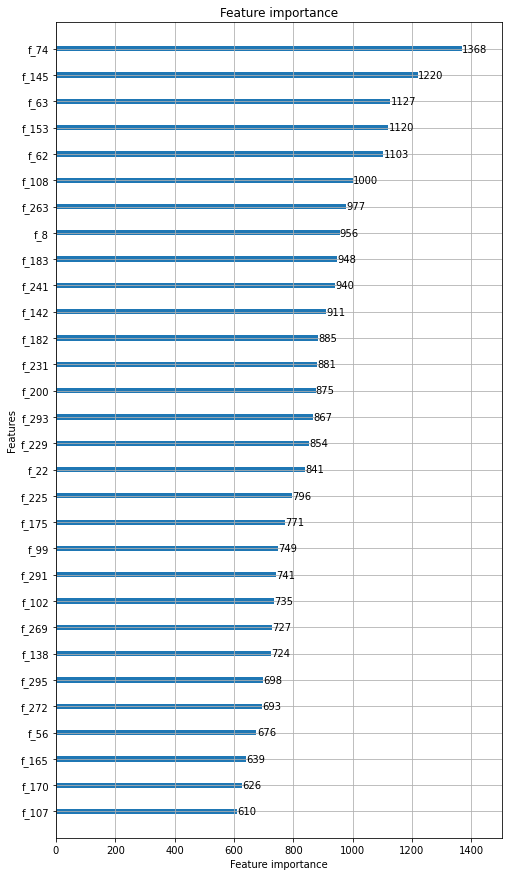

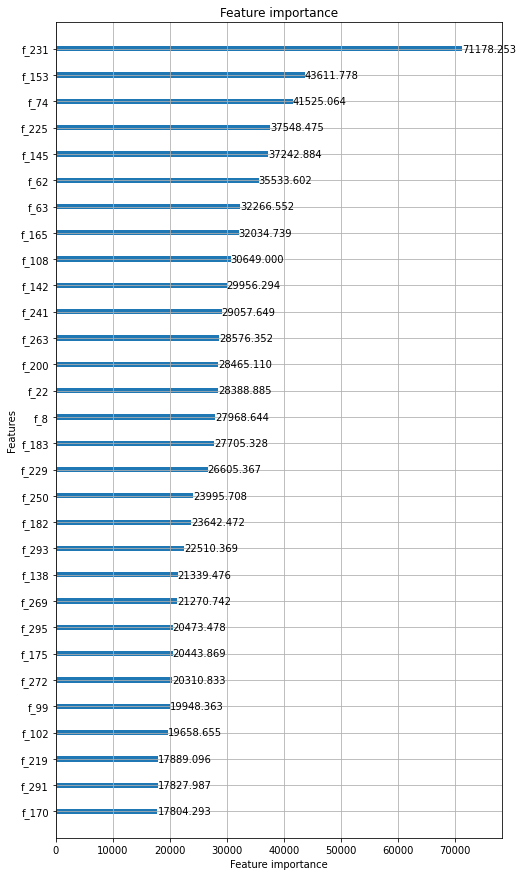

In [14]:
seeds = [2,7,11,19,23]
models = list()

train_dset = lgb.Dataset(
    data=features,
    label=target.target.values,
    free_raw_data=True,
)

for seed in seeds:
    _model_params = dict(model_params)
    _model_params["seed"] = seed
    
    log_callback = lgb.log_evaluation(period=20)
    
    model = lgb.train(
        params=_model_params,
        train_set=train_dset,
        valid_sets=[train_dset,],
        feval=pearsonr,
        callbacks=[log_callback,]
    )
    models.append(model)

    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()

In [15]:
for seed,model in zip(seeds,models): 
    model.save_model(f"../ump-artifacts/lgbm-gbrt/lgbm-seed{seed}.txt")

***
## inference

In [16]:
if current_env == "kaggle":

    import ubiquant
    env = ubiquant.make_env()  
    iter_test = env.iter_test()
    
    features = [f"f_{i}" for i in range(300)]
    for (test_df, sample_prediction_df) in iter_test:  
        preds = [model.predict(test_df[features]) for model in models]
        sample_prediction_df['target'] = np.mean(preds, axis=0)
        env.predict(sample_prediction_df) 
        display(sample_prediction_df)

***